In [111]:
#Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, pearsonr
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# EDA
## Exploring the Dataset and Target Variable

In [112]:
df = pd.read_csv('telco_churn.csv')
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


The dataset has 21 columns. Target column is Churn, which consists of Yes/No entries for each observation. 
The purpose of our study is to create a model that predicts whether a customer will churn. (Classification)

In [113]:
df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

Looking at the target variable, values are unbalanced. Only 26% of all data is Yes. Therefore we need to account for this imbalance while creating train-test datasets and evaluating prediction performance. F1 Score and Recall would give a better picture of prediction success for this data. 

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


There are no null values, and most features seem to be categorical. **SeniorCitizen** is normally a categorical variable, but here it seems to be numeric. We can update it as object for EDA. 
**TotalCharges** is a numeric variable, we should also change its data type as float64

In [115]:
#Update SeniorCitizen as a Categorical Feature
df['SeniorCitizen'] = df['SeniorCitizen'].map({0:'No',1:'Yes'})

In [116]:
#Totalcharges has some empty values, which are not null but only a space character
#Fill in ' ' values by month*tenure (tenure is 0 for these values)
df.loc[df['TotalCharges']==' ','TotalCharges'] = df.loc[df['TotalCharges']==' ','tenure']*df.loc[df['TotalCharges']==' ','MonthlyCharges']

In [117]:
#Update Totalcharges as numeric
df['TotalCharges'] = df['TotalCharges'].astype('float64')

## Numeric Variables

In [118]:
df.select_dtypes(include=np.number).describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


There are 3 numeric variables and with a std deviation close to mean value. Let's observe them with a boxplot

### Boxplot / Outlier Detection

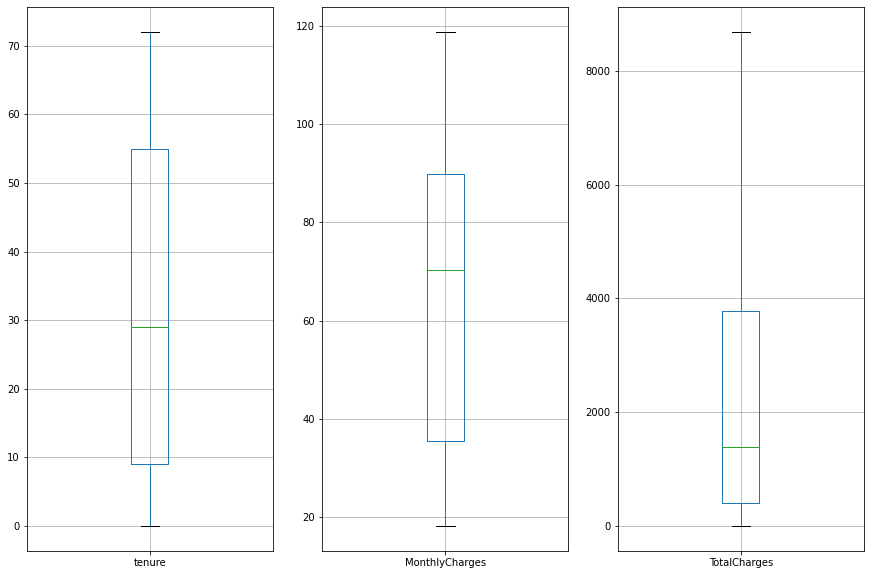

In [119]:
fig, axes = plt.subplots(1,3,figsize=(15,10))
df[['tenure']].boxplot(ax=axes[0])
df[['MonthlyCharges']].boxplot(ax=axes[1])
df[['TotalCharges']].boxplot(ax=axes[2]);

There are no outliers here, and but totalcharges seems related to the product of tenure and MonthlyCharges. We can calculate this product and check the correlation

In [120]:
total_series =df['tenure']*df['MonthlyCharges']

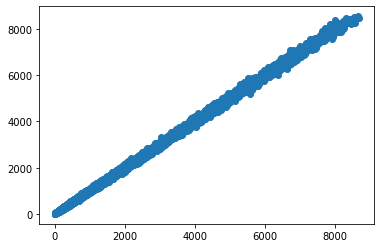

In [121]:
plt.scatter(df['TotalCharges'],total_series);

In [122]:
pearsonr(df['TotalCharges'],total_series)

(0.9995605537972277, 0.0)

From both the graph and the correlation coefficient, all information is in MonthlyCharges and tenure. Here my decision is to drop the TotalCharges col. 

In [123]:
df.drop('TotalCharges', axis=1, inplace=True)

### Distribution of numeric features and correlation to target

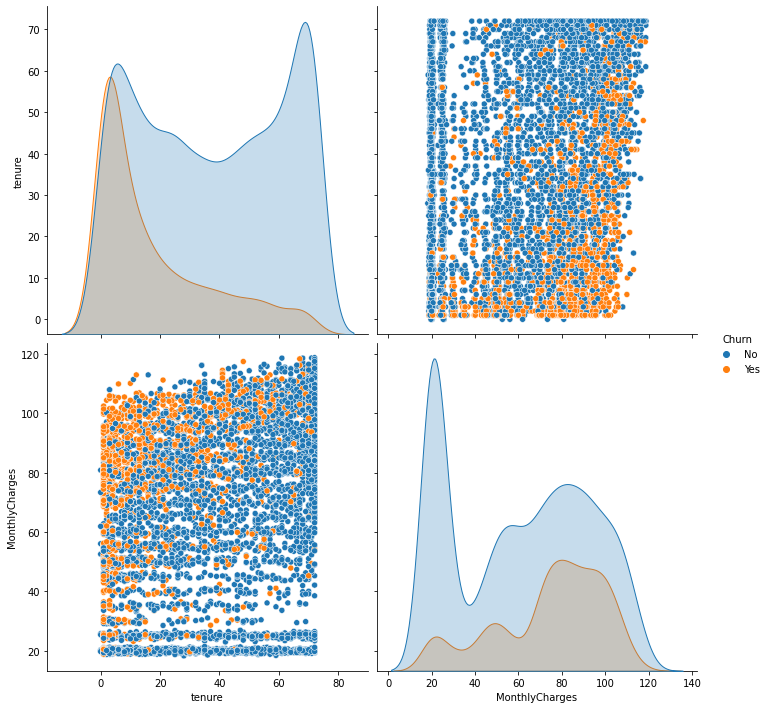

In [124]:
data = df[["tenure", "MonthlyCharges", "Churn"]]
sns.pairplot(data, hue="Churn", height=5);

In [125]:
df.loc[:,["tenure", "MonthlyCharges","Churn"]].corr()

,tenure,MonthlyCharges
tenure,1.0000,0.2479
MonthlyCharges,0.2479,1.0000


There is very small correlation between with tenure and monthly charges. Tenure distribution is skewed as most customers have smaller tenure months. Looking at the churn=yes points in scatterplot, we can conclude that customers with lower tenure and higher monthly charges have more churn risk. 

### Standardization

Most machine learning models used scalar distance for optimization
Z-Standardization should be applied to numeric variables.

In [126]:

scaler = StandardScaler()
df['tenure'] = scaler.fit_transform(df[['tenure']])
df['MonthlyCharges'] = scaler.fit_transform(df[['MonthlyCharges']])

### Categorical Variables

In [127]:
df.select_dtypes(include='object').describe()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


At first look, we can see that **customerID** is a customer identifier with unique value. Let's drop this column and keep it our of scope. 

In [128]:
df.drop('customerID', axis=1, inplace=True)

In [129]:
#Observe all categorical variables with churn
categorical_features = df.select_dtypes(include='object').drop('Churn',axis=1).columns.tolist()
for col in categorical_features:
    print(df[col].value_counts())
    print(df.groupby(col)['Churn'].value_counts(normalize=True))
    print('\n')

Male      3555
Female    3488
Name: gender, dtype: int64
gender  Churn
Female  No       0.730791
        Yes      0.269209
Male    No       0.738397
        Yes      0.261603
Name: Churn, dtype: float64


No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64
SeniorCitizen  Churn
No             No       0.763938
               Yes      0.236062
Yes            No       0.583187
               Yes      0.416813
Name: Churn, dtype: float64


No     3641
Yes    3402
Name: Partner, dtype: int64
Partner  Churn
No       No       0.670420
         Yes      0.329580
Yes      No       0.803351
         Yes      0.196649
Name: Churn, dtype: float64


No     4933
Yes    2110
Name: Dependents, dtype: int64
Dependents  Churn
No          No       0.687209
            Yes      0.312791
Yes         No       0.845498
            Yes      0.154502
Name: Churn, dtype: float64


Yes    6361
No      682
Name: PhoneService, dtype: int64
PhoneService  Churn
No            No       0.750733
              Yes

From above results we can see that when grouped **PhoneService** and **gender** variables, the yes/no ratio of target class does not change. We can also plot these variables for a closer look.

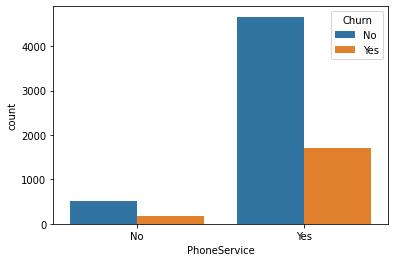

In [130]:
sns.countplot(x='PhoneService', hue='Churn', data=df);

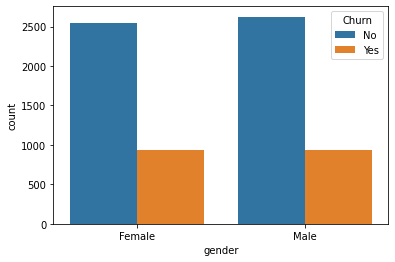

In [131]:
sns.countplot(x='gender', hue='Churn', data=df);

In [132]:
contingency_table = pd.crosstab(df['PhoneService'],df['Churn'], margins = False)
contingency_table

Churn,No,Yes
PhoneService,,
No,512,170
Yes,4662,1699


In [133]:
stat, p, dof, expected = chi2_contingency(contingency_table)
stat, p

(0.9150329892546948, 0.3387825358066928)

In [134]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['gender'],df['Churn'], margins = False))
stat, p

(0.4840828822091383, 0.48657873605618596)

Both the plots and correlation values indicate these features do not have correlation to targets. We can also drop these features.

In [135]:
df.drop(['gender', 'PhoneService'], axis=1, inplace=True)

### Encoding Categorical Variables

We first start with **Contract** column, which seems to have an order in itself. It can be encoded into ordered categories

In [136]:
df['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [137]:
from pandas.api.types import CategoricalDtype
contract_cat = CategoricalDtype(categories=['Month-to-month', 'One year', 'Two year'], ordered=True)
df['Contract'] = df['Contract'].astype(contract_cat).cat.codes

In [138]:
df['Contract'].value_counts()

0    3875
2    1695
1    1473
Name: Contract, dtype: int64

In [139]:
#One Hot Encoding
for column in df.drop('Churn', axis=1).select_dtypes(include=object).columns:
    print(f'{column} : {df[column].nunique()}')
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=True)], axis=1).drop(column, axis=1)
df.head()

SeniorCitizen : 2
Partner : 2
Dependents : 2
MultipleLines : 3
InternetService : 3
OnlineSecurity : 3
OnlineBackup : 3
DeviceProtection : 3
TechSupport : 3
StreamingTV : 3
StreamingMovies : 3
PaperlessBilling : 2
PaymentMethod : 4


,tenure,Contract,MonthlyCharges,Churn,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.277445,0,-1.160323,No,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.066327,1,-0.259629,No,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.236724,0,-0.362660,Yes,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0.514251,1,-0.746535,No,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,-1.236724,0,0.197365,Yes,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


## Prepare Train-Test Sets and Scoring Functions

In [140]:
X = df.drop('Churn', axis=1)
df['Churn'] = df['Churn'].factorize()[0]
y = df['Churn']

In [141]:
#30% of data points are reserved for test_set, and since target class is skewed, data points are stratified to keep the same balance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4930, 26), (2113, 26), (4930,), (2113,))

In [142]:
#Classification score to return accuracy, f1_score, classification_report and a confusion matrix
def classification_score(y_test, y_pred):
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy Score = {accuracy}\nF1 Score:{f1}\n')
    print(classification_report(y_test, y_pred))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred)[::-1,::-1], columns=['Pred_True', 'Pred_False'], index=['Act_True', 'Act_False']))

In [143]:
#This method returns f1, recall and accuracy scores
def evaluate_scores(y_test, y_pred):
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return f1, recall, accuracy

## Modelling - Evaluation

### Run Base Models

In [144]:
#Method to run model and return scores
def run_model(X_train, X_test, y_train, y_test, func):
    model = func()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_score, recall_score, accuracy_score = evaluate_scores(y_test, y_pred)
    model_name = str(model).split('(')[0]
    print(f'{model_name} Results\nf1_score: {f1_score}, recall: {recall_score}, accuracy: {accuracy_score},')
    return model_name, f1_score, recall_score, accuracy_score,

In [145]:
#Run all models are save the results
models = [LogisticRegression, SGDClassifier, KNeighborsClassifier, LinearSVC, RandomForestClassifier, XGBClassifier]
model_results = []
for model in models:
    model_results.append(run_model(X_train, X_test, y_train, y_test, model))
results_df = pd.DataFrame(model_results, columns=['model', 'f1_score','recall_score','accuracy'])
results_df

LogisticRegression Results
f1_score: 0.5908183632734532, recall: 0.5276292335115864, accuracy: 0.8059630856601988,
SGDClassifier Results
f1_score: 0.5976597659765978, recall: 0.5918003565062389, accuracy: 0.7884524372929484,
KNeighborsClassifier Results
f1_score: 0.5442804428044281, recall: 0.5258467023172906, accuracy: 0.7662091812588736,
LinearSVC Results
f1_score: 0.5878787878787879, recall: 0.5187165775401069, accuracy: 0.8069096071935636,
RandomForestClassifier Results
f1_score: 0.5540950455005056, recall: 0.48841354723707664, accuracy: 0.791292001893043,
[21:14:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Results
f1_score: 0.5797101449275363, recall: 0.5347593582887701, accuracy: 0.7941315664931378,


C:\Users\TCLSOYKAN\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,model,f1_score,recall_score,accuracy
0,LogisticRegression,0.590818,0.527629,0.805963
1,SGDClassifier,0.597660,0.591800,0.788452
2,KNeighborsClassifier,0.544280,0.525847,0.766209
3,LinearSVC,0.587879,0.518717,0.806910
4,RandomForestClassifier,0.554095,0.488414,0.791292
5,XGBClassifier,0.579710,0.534759,0.794132


These are the results of 6 different models with default settings. Comparing the f1-recall scores LogisticRegression, KNN and XGBClassifier seem to perform better.

### Displaying Feature Importances

We can use the feature importance attribute of RandomForestClassifier to see which features have larger effect on our predictions

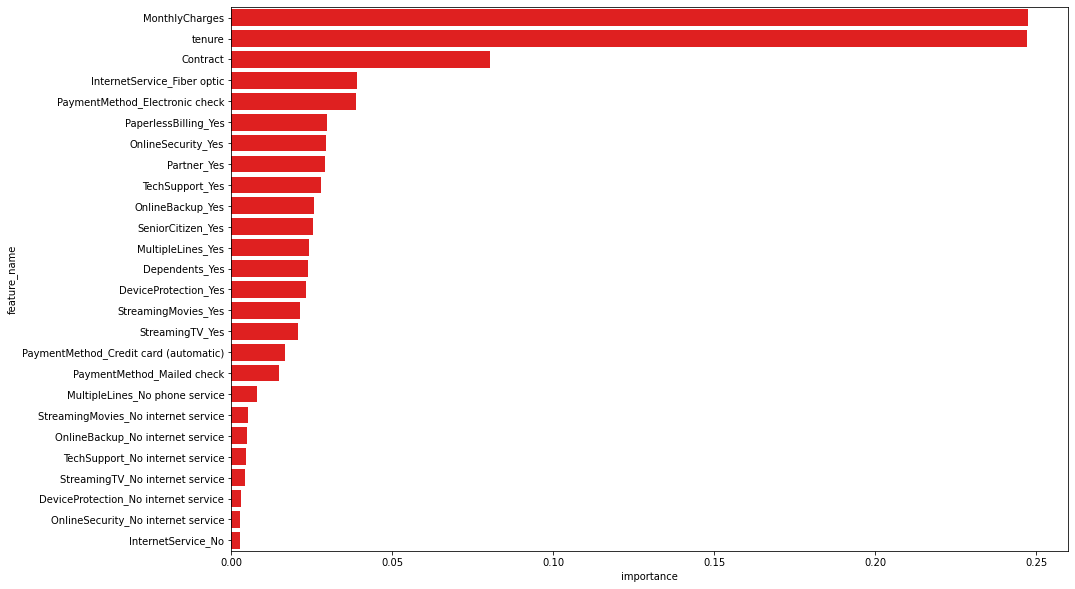

In [146]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(15,10))
feature_df = pd.DataFrame({'feature_name': X_train.columns, 'importance': rfc.feature_importances_}).sort_values(by='importance', ascending=False)
sns.barplot(x='importance', y='feature_name', data=feature_df, color='r', ax=ax);

### Model Tuning

In [147]:
#Method to tune models using GridSearch and store the results
def tune_model(X_train, X_test, y_train, y_test, func, param_grid):
    model = func()
    cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', verbose=-1, n_jobs=-1)
    cv.fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    f1_score, recall_score, accuracy_score = evaluate_scores(y_test, y_pred)
    model_name = str(model).split('(')[0]
    print(f'{model_name} Results\nf1_score: {f1_score}, recall: {recall_score}, accuracy: {accuracy_score},')
    return model_name, f1_score, recall_score, accuracy_score, cv.best_params_

In [148]:
#Prepare grids to be tuned for each model
param_grid_logreg = {'C':np.linspace(0,2, 6)}
param_grid_sgd = {'alpha': np.linspace(0.0001,1,5),
 'l1_ratio': np.linspace(0.15,0.9,5),
 'class_weight': [None,'balanced'],
 'loss': ['hinge','squared_hinge'],
 'penalty': ['l1']}
param_grid_knn = {'n_neighbors' : np.arange(3,15,2)}
param_grid_svm = {'C': np.linspace(0.0001,2,10)}
param_grid_rfc = {
 'max_depth': [10, 50, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}
param_grid_xgb = {
 'max_depth': np.arange(3,10), 'colsample_bytree': np.linspace(0.3,1, 5), 'min_child_weight':range(1,6,2), 'objective':['reg:logistic','binary:logistic']}
grids= [param_grid_logreg, param_grid_sgd, param_grid_knn, param_grid_svm, param_grid_rfc, param_grid_xgb]

In [149]:
#Tune all models and store results in a dataframe
models = [LogisticRegression, SGDClassifier, KNeighborsClassifier, LinearSVC, RandomForestClassifier, XGBClassifier]
cv_results = []
for model, param_grid in zip(models, grids):
    cv_results.append(tune_model(X_train, X_test, y_train, y_test, model, param_grid))
cv_results_df = pd.DataFrame(cv_results, columns=['model', 'f1_score','recall_score','accuracy', 'params'])
cv_results_df

C:\Users\TCLSOYKAN\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.5858643  0.58606884 0.58631524 0.58582074 0.58582074]
  warnings.warn(


LogisticRegression Results
f1_score: 0.5894105894105894, recall: 0.5258467023172906, accuracy: 0.8054898248935163,
SGDClassifier Results
f1_score: 0.6347760060744115, recall: 0.7450980392156863, accuracy: 0.7723615712257453,
KNeighborsClassifier Results
f1_score: 0.55765595463138, recall: 0.5258467023172906, accuracy: 0.7785139611926172,
LinearSVC Results
f1_score: 0.5878787878787879, recall: 0.5187165775401069, accuracy: 0.8069096071935636,
RandomForestClassifier Results
f1_score: 0.5749486652977412, recall: 0.49910873440285203, accuracy: 0.804070042593469,
XGBClassifier Results
f1_score: 0.576735092864125, recall: 0.5258467023172906, accuracy: 0.7950780880265026,


C:\Users\TCLSOYKAN\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,model,f1_score,recall_score,accuracy,params
0,LogisticRegression,0.589411,0.525847,0.805490,{'C': 1.2000000000000002}
1,SGDClassifier,0.634776,0.745098,0.772362,"{'alpha': 0.0001, 'class_weight': 'balanced', ..."
2,KNeighborsClassifier,0.557656,0.525847,0.778514,{'n_neighbors': 13}
3,LinearSVC,0.587879,0.518717,0.806910,{'C': 0.8889444444444444}
4,RandomForestClassifier,0.574949,0.499109,0.804070,"{'max_depth': 10, 'max_features': 'auto', 'min..."
5,XGBClassifier,0.576735,0.525847,0.795078,"{'colsample_bytree': 1.0, 'max_depth': 4, 'min..."


After tuning, SGDClassifier has reached a higher f1score.
Test set can be used to evaluate this model and analyze detailed classification report

### Evaluation 

In [150]:
cv_results_df.iloc[1, 4]

{'alpha': 0.0001,
 'class_weight': 'balanced',
 'l1_ratio': 0.7125,
 'loss': 'hinge',
 'penalty': 'l1'}

In [151]:
sgd_cfl = SGDClassifier(alpha= 0.0001,
 l1_ratio= 0.7125,
 class_weight= 'balanced',
 loss='hinge',
 penalty= 'l1')

In [152]:
sgd_cfl.fit(X_train, y_train)

SGDClassifier(class_weight='balanced', l1_ratio=0.7125, penalty='l1')

In [153]:
preds = sgd_cfl.predict(X_test)

In [154]:
classification_score(y_test, preds)

Accuracy Score = 0.7728348319924279
F1 Score:0.6238244514106582

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1552
           1       0.56      0.71      0.62       561

    accuracy                           0.77      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.77      0.78      2113

           Pred_True  Pred_False
Act_True         398         163
Act_False        317        1235


COMMENTS ON REPORT
* %77 Accuract is low, considering that our target values are %73 No and %27 yes
* F1 score and recall seems to better (we made the tuning for f1 score). 
* 71% Recall makes this model preferable as we do not want to miss a potential churn. 
* In the confusion matrix, we can see that of all 561 churns we have predicted 398 correctly

### FURTHER STEPS
* Target Encoding can be used for encoding numerical variables
* RandomSearchCV can be applied, using larger search spaces
* We can use Model Blending & Ensemble for better evaluation
* Polynomial features can be generated and included in training-evaluation